In [27]:
%matplotlib inline
import math
import numpy as np

from scipy import integrate
from scipy import interpolate
from scipy.integrate import odeint

import matplotlib.pyplot as plt

from nbodykit.lab import *

In [28]:
cosmo = cosmology.Planck15

In [34]:
Omega_m = cosmo.Omega_m(0)
Omega_L = cosmo.Omega_lambda(0)
tau_array = [0.005,0.005,-0.01]
a_begin = 1/(1+200)
a_end = 1
points = 5000

def Hubble(a):
    matter = Omega_m/a**3
    Lambda = Omega_L
    return np.sqrt(matter+Lambda)

def dHda(a):
    up = -3*Omega_m
    down = 2*a**4*Hubble(a)
    return up/down

def dHdloga(a):
    return a*dHda(a)

def growth_int(a):
    return 1./(a*Hubble(a))**3

def growth_D(a):
    factor = 5*Omega_m*Hubble(a)/2
    return factor*integrate.quad(growth_int, 0, a)[0]

def dDda(a):
    factor = 5*Omega_m*dHda(a)/2
    second = 5*Omega_m/(2*a**3*Hubble(a)**2)
    return factor*integrate.quad(growth_int, 0, a)[0] + second

def dDdloga(a):
    return a*dDda(a)

vgrowth_D = np.vectorize(growth_D)
vdDda = np.vectorize(dDda)
vdDdloga = np.vectorize(dDdloga)

In [35]:
a_array = np.logspace(np.log(a_begin), np.log(1), points, base=np.exp(1))
lna_array = np.log(a_array)
a_da = np.zeros((points,6))

def Delta_f(x, lna, taux, tauy, tauz):
    ### x0 = Delta_x, x1 = Delta_x', x2 = Delta_y, x3 = Delta_y', x4 = Delta_z, x5 = Delta_z'
    Delta0 = 1/((1.+x[0])*(1.+x[2])*(1.+x[4]))-1.
    #Delta0 = 0
    a = np.exp(lna)
    first = 2+dHdloga(a)/Hubble(a)
    
    def tau_time(tau):
        return tau*vgrowth_D(a)/vgrowth_D(1) 
    
    const = 3*Omega_m/(2*a**3*Hubble(a)**2)
    ret = [
        x[1],
        -first*x[1] -const*(tau_time(taux)+Delta0/3.)*(1+x[0]),
        x[3],
        -first*x[3] -const*(tau_time(tauy)+Delta0/3.)*(1+x[2]),
        x[5],
        -first*x[5] -const*(tau_time(tauz)+Delta0/3.)*(1+x[4]),
    ]
    return ret

inifac = growth_D(a_array[0])/growth_D(1)
dinifac = inifac*vdDdloga(a_array[0])/growth_D(a_array[0])

Delta_ini = -np.array([tau_array[0]*inifac, tau_array[0]*dinifac,
                      tau_array[1]*inifac, tau_array[1]*dinifac,
                      tau_array[2]*inifac, tau_array[2]*dinifac])

a_da = odeint(Delta_f, Delta_ini, lna_array, args=(tau_array[0],tau_array[1],tau_array[2]))

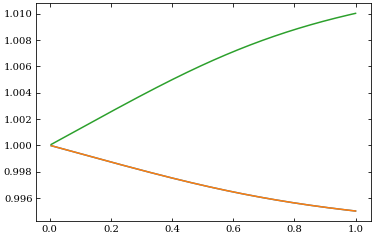

In [36]:
plt.plot(a_array,1+a_da[:,0])
plt.plot(a_array,1+a_da[:,2])
plt.plot(a_array,1+a_da[:,4])

In [37]:
ai_save = np.zeros((points,4))
ai_save[:,0] = a_array
ai_save[:,1] = a_da[:,0]
ai_save[:,2] = a_da[:,2]
ai_save[:,3] = a_da[:,4]
print(ai_save)

[[ 4.97512438e-03 -3.17175339e-05 -3.17175339e-05  6.34350678e-05]
 [ 4.98040515e-03 -3.17512133e-05 -3.17512133e-05  6.35024266e-05]
 [ 4.98569154e-03 -3.17849158e-05 -3.17849158e-05  6.35698316e-05]
 ...
 [ 9.97880503e-01 -4.99136400e-03 -4.99136400e-03  1.00148356e-02]
 [ 9.98939689e-01 -4.99412864e-03 -4.99412864e-03  1.00204011e-02]
 [ 1.00000000e+00 -4.99689138e-03 -4.99689138e-03  1.00259629e-02]]


In [38]:
np.savetxt('Aniss_planck15_p0005p0005m001_z200',ai_save)